# Which kind of Movie will get Higher Rating

Netflix has a lot of quality movies and series with different genres under different categories. Netflixers have to search through Netflix to know which contents is better quality. That is uneasy and a bit time consuming. Hidden gem addresses such problem.

The business idea behind this problem is to know which type of movie can get higher ranting and popular among viewers. Technically, it is about the prediction of Hidden Gem Score of Netflix Movies. The predicted score will support for those whose business is related with movie like movie production industries.

In this notebook, there will be 3 different implementation for business understanding.
1. Which genre of movies or series are the most showed on Netflix from year 2015 to 2021.
2. How the movie published trend on Netflix changed.
3. The Prediction of Hidden Gem Score

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Dataset

The dataset is downloaded from Kaggle. The dataset contains the information about movie and its hidden gem score. This dataset combines the data sourced by Netflix, Rotten Tomatoes, IMBD, posters, box office, trailers on YouTube, and more.

In [2]:
dataset = pd.read_csv('./netflix-rotten-tomatoes-metacritic-imdb.csv')

Take a closer look to data to understand dataset nature and its information.

In [3]:
dataset.head()

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,...,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,...,04/03/2021,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,NaN,NaN
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,...,04/03/2021,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,Canada,1-2 hour,Brendan Walsh,"Brendan Walsh, Daley Nixon",...,04/03/2021,NaN,https://www.netflix.com/watch/81305978,https://www.imdb.com/title/tt8945942,"Trapped in a frozen car during a blizzard, a p...",1720.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BODM2MD...,https://www.youtube.com/watch?v=0RvV7TNUlkQ,YouTube
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,"Belgium,Netherlands",< 30 minutes,NaN,NaN,...,04/03/2021,NaN,https://www.netflix.com/watch/81336456,https://www.imdb.com/title/tt6132758,"Upon moving into a new place, a 20-something r...",1147.0,https://occ-0-1489-1490.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BNWRkMz...,NaN,NaN
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",1-2 hour,Stephen Irwin,NaN,...,04/03/2021,NaN,https://www.netflix.com/watch/81078393,https://www.imdb.com/title/tt2023611,Inspired by her moms rebellious past and a con...,63.0,https://occ-0-4039-1500.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BODYyNW...,NaN,NaN


The dataset has over 15,000 data records corresponding to 29 features.

In [4]:
dataset.shape

(15480, 29)

Before performing analysis on dataset, it is required to choose the feature columns which required for my case scenario. 

14 out of 29 columns are selected as feature in this scenario. Title, Genre, Tags, English, Series or Movie, Hidden Gem Score, Run Time, IMDb Score, Rotten Tomatoes Score, Metacritic Score, Awards Received, Awards Nominated For, Boxoffice, Netflix Release Data and IMDb Votes.

In [5]:
#Feature columns in dataset
dataset = dataset[['Title','Genre', 'Languages', 'Series or Movie',
       'Hidden Gem Score', 'Runtime', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Netflix Release Date', 'IMDb Votes']]

### Understanding a bit more about data

Data transformation is also required to perform to some features like Boxoffice (string to int).

In [6]:
dataset['Boxoffice'] = dataset['Boxoffice'].str.replace('$','')
dataset['Boxoffice'] = dataset['Boxoffice'].str.replace(',','')

In [7]:
pd.to_numeric(dataset['Boxoffice'])

0        2122065.0
1          70632.0
2          16263.0
3              NaN
4              NaN
           ...    
15475          NaN
15476          NaN
15477          NaN
15478          NaN
15479          NaN
Name: Boxoffice, Length: 15480, dtype: float64

Find any missing value in the dataset and handle the missing value. If the missing value finds necessary, fill the missing value with some values, mean and standard deviation. If it finds unimportant, remove them before it leads to outliers.

In [8]:
#checking the missing value.
dataset.isnull().sum()

Title                        0
Genre                     1710
Languages                 1935
Series or Movie              0
Hidden Gem Score          2101
Runtime                      0
IMDb Score                2099
Rotten Tomatoes Score     9098
Metacritic Score         11144
Awards Received           9405
Awards Nominated For      7819
Boxoffice                11473
Netflix Release Date         0
IMDb Votes                2101
dtype: int64

In [9]:
#handle the missing value
dataset = dataset.dropna(subset=['Hidden Gem Score'])

dataset['Rotten Tomatoes Score'] = dataset['Rotten Tomatoes Score'].fillna(0)
dataset['Metacritic Score'] = dataset['Rotten Tomatoes Score'].fillna(0)
dataset['Awards Received'] = dataset['Awards Received'].fillna(0)
dataset['Awards Nominated For'] = dataset['Awards Nominated For'].fillna(0)
dataset['Boxoffice'] = dataset['Boxoffice'].fillna(0)

dataset = dataset.dropna(subset=['Genre','Languages'])

In [10]:
dataset.isnull().sum()

Title                    0
Genre                    0
Languages                0
Series or Movie          0
Hidden Gem Score         0
Runtime                  0
IMDb Score               0
Rotten Tomatoes Score    0
Metacritic Score         0
Awards Received          0
Awards Nominated For     0
Boxoffice                0
Netflix Release Date     0
IMDb Votes               0
dtype: int64

There is no missing value now.

## Business Understanding
### 1. Which genre of movies or series are the most showed on Netflix

There are a lot of genre of movies and series published on Netflix. This session will answer which genre of movie or series are released the most from 2015 to 2021.

In [11]:
def count_genre():
    genre = []
    genre.append(', '.join(dataset['Genre']).split(', '))
    return Counter(genre[0])

genre_dict = count_genre()

In [12]:
# create dataframe for frequency graph
genre_dict = nltk.FreqDist(genre_dict) 

genre_df = pd.DataFrame({'Genre': list(genre_dict.keys()), 
'Count': list(genre_dict.values())})

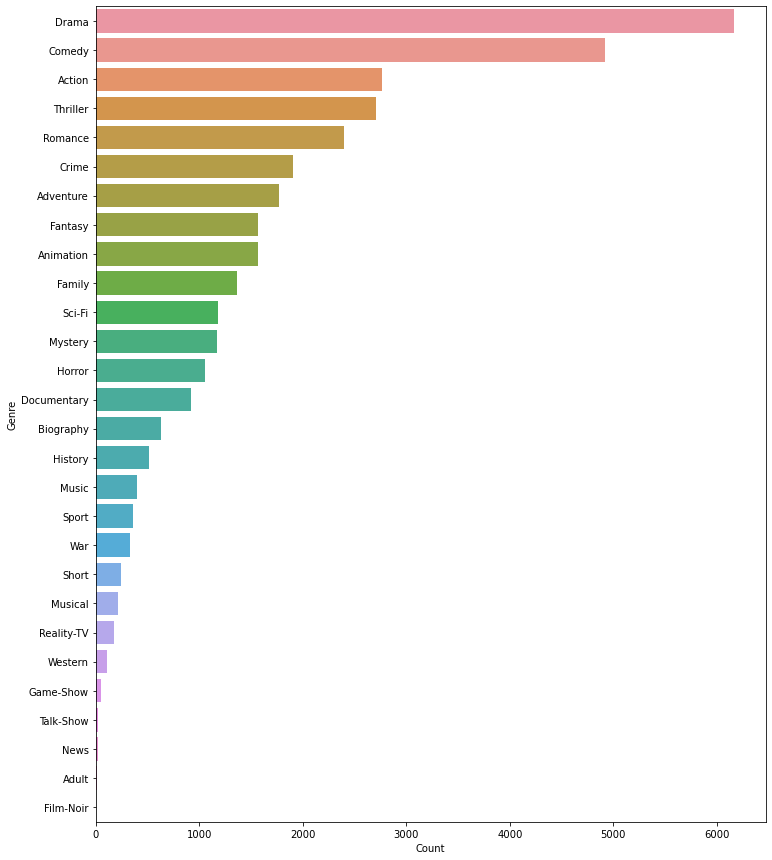

In [13]:
#plout the graph
g = genre_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

According to the plot, it is assumed that 5 most showed movie genre are <b> Drama, Comedy, Action, Thriller, and Romance. </b> 

### 2. How movie published trend on Netflix changed

A lot of movies or series are released every year. In the session, we are going to see how the trend changes from 2015 to 2021. Based on this result, we can consider in which year, what will be the trend.

In [14]:
#get Year from Netflix release date
dataset['Year'] = pd.DatetimeIndex(dataset['Netflix Release Date']).year
dataset = dataset.drop(['Netflix Release Date'], axis = 1)

In [15]:
# Drama Trend between 2015 and 2021
drama_count_y2015 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2015)])
drama_count_y2016 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2016)])
drama_count_y2017 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2017)])
drama_count_y2018 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2018)])
drama_count_y2019 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2019)])
drama_count_y2020 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2020)])
drama_count_y2021 = (dataset[(dataset['Genre'].str.contains('Drama')) & (dataset['Year'] == 2021)])

dramas = []
dramas.append(drama_count_y2015['Genre'].count())
dramas.append(drama_count_y2016['Genre'].count())
dramas.append(drama_count_y2017['Genre'].count())
dramas.append(drama_count_y2018['Genre'].count())
dramas.append(drama_count_y2019['Genre'].count())
dramas.append(drama_count_y2020['Genre'].count())
dramas.append(drama_count_y2021['Genre'].count())

In [16]:
# Action Trend between 2015 and 2021
drama_count_y2015 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2015)])
drama_count_y2016 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2016)])
drama_count_y2017 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2017)])
drama_count_y2018 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2018)])
drama_count_y2019 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2019)])
drama_count_y2020 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2020)])
drama_count_y2021 = (dataset[(dataset['Genre'].str.contains('Action')) & (dataset['Year'] == 2021)])

actions = []
actions.append(drama_count_y2015['Genre'].count())
actions.append(drama_count_y2016['Genre'].count())
actions.append(drama_count_y2017['Genre'].count())
actions.append(drama_count_y2018['Genre'].count())
actions.append(drama_count_y2019['Genre'].count())
actions.append(drama_count_y2020['Genre'].count())
actions.append(drama_count_y2021['Genre'].count())

In [17]:
# Comedy Trend between 2015 and 2021
drama_count_y2015 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2015)])
drama_count_y2016 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2016)])
drama_count_y2017 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2017)])
drama_count_y2018 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2018)])
drama_count_y2019 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2019)])
drama_count_y2020 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2020)])
drama_count_y2021 = (dataset[(dataset['Genre'].str.contains('Comedy')) & (dataset['Year'] == 2021)])

comedies = []
comedies.append(drama_count_y2015['Genre'].count())
comedies.append(drama_count_y2016['Genre'].count())
comedies.append(drama_count_y2017['Genre'].count())
comedies.append(drama_count_y2018['Genre'].count())
comedies.append(drama_count_y2019['Genre'].count())
comedies.append(drama_count_y2020['Genre'].count())
comedies.append(drama_count_y2021['Genre'].count())

In [18]:
# Thriller Trend between 2015 and 2021
drama_count_y2015 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2015)])
drama_count_y2016 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2016)])
drama_count_y2017 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2017)])
drama_count_y2018 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2018)])
drama_count_y2019 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2019)])
drama_count_y2020 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2020)])
drama_count_y2021 = (dataset[(dataset['Genre'].str.contains('Thriller')) & (dataset['Year'] == 2021)])

thrillers = []
thrillers.append(drama_count_y2015['Genre'].count())
thrillers.append(drama_count_y2016['Genre'].count())
thrillers.append(drama_count_y2017['Genre'].count())
thrillers.append(drama_count_y2018['Genre'].count())
thrillers.append(drama_count_y2019['Genre'].count())
thrillers.append(drama_count_y2020['Genre'].count())
thrillers.append(drama_count_y2021['Genre'].count())

In [19]:
year_gem_score_df = pd.DataFrame()

#years (2015 to 2021)
years = sorted(dataset['Year'].unique())
year_gem_score_df['Year'] = years

#movie count for drama, action, comedy and thriller
year_gem_score_df['Drama Movie Count'] = dramas
year_gem_score_df['Action Movie Count'] = actions
year_gem_score_df['Comedy Movie Count'] = comedies
year_gem_score_df['Thriller Movie Count'] = thrillers

In [20]:
#a new dataframe of movie count by years
year_gem_score_df

,Year,Drama Movie Count,Action Movie Count,Comedy Movie Count,Thriller Movie Count
0,2015,1471,907,1272,802
1,2016,603,313,456,298
2,2017,682,315,531,291
3,2018,812,383,753,359
4,2019,975,363,813,368
5,2020,1371,408,941,495
6,2021,249,71,154,89


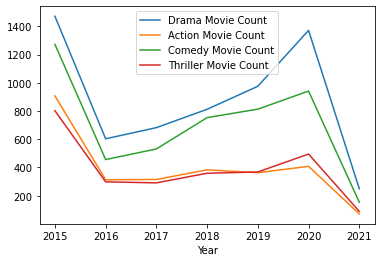

In [21]:
year_gem_score_df.plot.line(x='Year')

According to the plot, we can clearly see that movie published on Netflix has similar trend, but in 2016 and 2019, the movie published quantity has less compared with the other years. Other than that, from 2019, thriller movies have more chance to published on Netflix than action movies.

## Prediction of Hidden Gem Score

The prediction of hidden gem score in a given movie helps for further movie production. The movie industry can decide whether the movie about to produce can get a higher rating or not.

For the first step, we need to do the one-hot encoding for expression of the categorical data like Genre, Runtime, Series or Movie, and Language.

In [22]:
#create dummies data for Genre
def one_hot_encoding_genre():
    genres = np.unique(', '.join(dataset['Genre']).split(', '))
    ### Drop 'NA'
    genres = np.delete(genres, np.where(genres == 'NA'))
    for genre in genres:
        print(genre)
        dataset[genre] = dataset['Genre'].str.contains(genre).astype('int')
        
one_hot_encoding_genre()
dataset.drop('Genre', axis=1, inplace=True)

Action
Adult
Adventure
Animation
Biography
Comedy
Crime
Documentary
Drama
Family
Fantasy
Film-Noir
Game-Show
History
Horror
Music
Musical
Mystery
News
Reality-TV
Romance
Sci-Fi
Short
Sport
Talk-Show
Thriller
War
Western


In [23]:
#create dummies data for Runtime
runtime_dummies = pd.get_dummies(dataset['Runtime'])
dataset = dataset.join(runtime_dummies)
dataset.drop('Runtime', axis=1, inplace=True)

In [24]:
#create dummies data for Series or Movie
type_dummies = pd.get_dummies(dataset['Series or Movie'])
dataset = dataset.join(type_dummies)
dataset.drop('Series or Movie', axis=1, inplace=True)

In [25]:
#create dummies data for Language
def one_hot_encoding_language():
    languages = np.unique(', '.join(dataset['Languages']).split(', '))
    ### Drop 'NA'
    languages = np.delete(languages, np.where(languages == 'NA'))
    for language in languages:
        print(language)
        dataset[language] = dataset['Languages'].str.contains(language).astype('int')

one_hot_encoding_language()
dataset.drop('Languages', axis=1, inplace=True)

 Ancient (to 1453)
 Old
Aboriginal
Acholi
Afrikaans
Akan
Albanian
Algonquin
American Sign Language
Amharic
Apache languages
Arabic
Aragonese


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Aramaic
Armenian
Aromanian
Assamese
Awadhi
Azerbaijani
Bable
Basque
Belarusian
Bengali
Berber languages
Bhojpuri
Bosnian
Brazilian Sign Language
Breton
British Sign Language
Bulgarian
Burmese
Cantonese
Catalan
Central American Indian languages
Chechen
Cheyenne
Chinese
Cornish
Cree
Croatian
Czech
Danish
Dari
Dinka
Dutch
East-Greenlandic
Egyptian (Ancient)
English
Esperanto
Estonian
Faroese
Filipino
Finnish
Flemish
French
French Sign Language
Fulah
Gallegan
Georgian
German
Greek
Greenlandic
Gujarati
Haitian
Hakka
Hausa
Hawaiian
Hebrew
Hindi
Hmong
Hokkien
Hungarian
Ibo
Icelandic
Indonesian
Inuktitut
Irish
Italian
Japanese
Japanese Sign Language
Kannada
Kazakh
Khmer
Kikuyu
Kinyarwanda
Klingon
Korean
Korean Sign Language
Kriolu
Kurdish
Lao
Latin
Latvian
Lingala
Lithuanian
Luxembourgish
Malay
Malayalam
Malinka
Maltese
Mandarin
Manipuri
Maori
Mapudungun
Marathi
Maya
Mende
Min Nan
Mixtec
Mohawk
Mongolian
Nahuatl
Nama
Navajo
Neapolitan
Nepali
None
Norse
North American Indian
Norwegian
Nyanja
Oc

In [26]:
#drop Title as it is not required for this case
dataset.drop('Title', axis=1, inplace=True)

In [27]:
dataset

,Hidden Gem Score,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,IMDb Votes,Year,Action,...,Urdu,Uzbek,Vietnamese,Wayuu,Welsh,Wolof,Xhosa,Yiddish,Yoruba,Zulu
0,4.3,7.9,98.0,98.0,74.0,57.0,2122065,205926.0,2021,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,5.8,79.0,79.0,1.0,0.0,70632,2838.0,2021,0,...,0,0,0,0,0,0,0,0,0,0
2,6.4,4.3,0.0,0.0,0.0,0.0,16263,1720.0,2021,0,...,0,0,0,0,0,0,0,0,0,0
3,7.7,6.5,0.0,0.0,1.0,0.0,0,1147.0,2021,0,...,0,0,0,0,0,0,0,0,0,0
4,8.1,6.3,0.0,0.0,0.0,4.0,0,63.0,2021,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,8.6,7.3,0.0,0.0,0.0,0.0,0,14.0,2015,0,...,0,0,0,0,0,0,0,0,0,0
15473,8.8,7.8,0.0,0.0,0.0,0.0,0,174.0,2015,0,...,0,0,0,0,0,0,0,0,0,0
15477,8.4,6.8,0.0,0.0,0.0,0.0,0,71.0,2015,0,...,0,0,0,0,0,0,0,0,0,0
15478,8.2,6.4,0.0,0.0,0.0,0.0,0,82.0,2015,0,...,0,0,0,0,0,0,0,0,0,0


The dataset is ready for training.

For the next step, we need to prepare training and testing features and target. This is Regression problem and the target will be hidden gem score and the system will predict the hidden score of a movie.

In [28]:
#prepare features and target
X_train = dataset.drop('Hidden Gem Score', axis = 1)
y_train = dataset['Hidden Gem Score']

70% of dataset will be the train data and the rest 30% will be the test data.

In [29]:
#split the dataset with 0.3 test size
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3)

In [30]:
#dimension of data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9170, 232)
(9170,)
(3930, 232)
(3930,)


Train the model with Random Forest Regressor because the data has mixed with both cate

In [31]:
#Random Forest Regressor is chosen as training model
model = RandomForestRegressor(random_state = 1)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

Evaluate the training performance with train data and the testing performance with test data. Mean absolute error (MAE) is used to calculate the error between the ground truth value and predicted value.

In [32]:
train_result = model.predict(X_train)
print(train_result)
train_mae = mean_absolute_error(y_train,train_result)
print('Training MAE %3f' % train_mae)

[7.822 5.321 8.8   ... 5.038 4.177 2.22 ]
Training MAE 0.030852


In [33]:
test_result = model.predict(X_test)
print(test_result)
test_mae = mean_absolute_error(y_test,test_result)
print('Testing MAE %3f' % test_mae)

[3.026 7.979 3.401 ... 7.797 2.513 2.957]
Testing MAE 0.079843
